### Importing the libraries

In [1]:
import re
import os
import nltk
import string
import zipfile
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

### Extracting the dataset from zip file

In [2]:
zip_file_path = r'C:\Users\harma\Downloads\archive.zip'

output_directory = r'C:\Users\harma\Desktop\Fellowship'

# Create the output directory if it doesn't exist
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

# Open the .zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    # Extract all contents to the output directory
    zip_ref.extractall(output_directory)

print(f"Contents of {zip_file_path} extracted to {output_directory}")

Contents of C:\Users\harma\Downloads\archive.zip extracted to C:\Users\harma\Desktop\Fellowship


### Reading the data

In [3]:
df = pd.read_csv("IMDB Dataset.csv")
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


### Analysis on the imdb dataset

In [4]:
# checking the number of rows and columns in the dataset
df.shape

(50000, 2)

In [5]:
# checking the info regarding the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [6]:
df.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


#### Conclusion from the data analysis phase
From the above we can see that we have total 50000 rows and 2 columns (review,sentiment) <br />
There are duplicates present in the dataset

### Text Preprocessing

In [7]:
df.review[0]

"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fa

In [8]:
df.review[2]

'I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. The plot is simplistic, but the dialogue is witty and the characters are likable (even the well bread suspected serial killer). While some may be disappointed when they realize this is not Match Point 2: Risk Addiction, I thought it was proof that Woody Allen is still fully in control of the style many of us have grown to love.<br /><br />This was the most I\'d laughed at one of Woody\'s comedies in years (dare I say a decade?). While I\'ve never been impressed with Scarlet Johanson, in this she managed to tone down her "sexy" image and jumped right into a average, but spirited young woman.<br /><br />This may not be the crown jewel of his career, but it was wittier than "Devil Wears Prada" and more interesting than "Superman" a great comedy to go see with friends.'

<b> From the above we can see that we have some html tags, numbers and punctuation marks.</b>

In [9]:
# creating the set for stopwords that needs to be removed
stop_words = set(stopwords.words('english'))
# creating the object for performing lemmatization
lemmatizer = WordNetLemmatizer()

In [10]:
def clean_text(text):
    '''Function to clean the text'''
    # removing the html tags
    result = re.sub(r'<.*?>', ' ', text)
    # removing numbers from the text
    result = re.sub("^\d+\s|\s\d+\s|\s\d+$", " ", result)
    # removing the punctuation from the text
    result = result.translate(str.maketrans('','',string.punctuation))
    # making all the words in lower case
    result = result.lower()
    # performing tokenization
    text_tokens = word_tokenize(result)
    # removing the stopwords
    filtered_words = [w for w in text_tokens if not w in stop_words]
    # joining the words after removing stop words
    result = " ".join(filtered_words)
    # returning the result
    return result

df['cleaned_text'] = df['review'].apply(lambda text: clean_text(text))

In [11]:
df.head()

,review,sentiment,cleaned_text
0,One of the other reviewers has mentioned that ...,positive,one reviewers mentioned watching oz episode yo...
1,A wonderful little production. <br /><br />The...,positive,wonderful little production filming technique ...
2,I thought this was a wonderful way to spend ti...,positive,thought wonderful way spend time hot summer we...
3,Basically there's a family where a little boy ...,negative,basically theres family little boy jake thinks...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,petter matteis love time money visually stunni...


In [12]:
df.cleaned_text[0]

'one reviewers mentioned watching oz episode youll hooked right exactly happened first thing struck oz brutality unflinching scenes violence set right word go trust show faint hearted timid show pulls punches regards drugs sex violence hardcore classic use word called oz nickname given oswald maximum security state penitentary focuses mainly emerald city experimental section prison cells glass fronts face inwards privacy high agenda em city home manyaryans muslims gangstas latinos christians italians irish moreso scuffles death stares dodgy dealings shady agreements never far away would say main appeal show due fact goes shows wouldnt dare forget pretty pictures painted mainstream audiences forget charm forget romanceoz doesnt mess around first episode ever saw struck nasty surreal couldnt say ready watched developed taste oz got accustomed high levels graphic violence violence injustice crooked guards wholl sold nickel inmates wholl kill order get away well mannered middle class inmat

#### Removing duplicates from the dataset

In [13]:
df.duplicated().sum()

418

In [14]:
df.drop_duplicates(inplace=True)
df.shape

(49582, 3)

### Performing lemmatization on the cleaned text

In [15]:
def lemmatization(text):
    text = text.split(" ")
    text = [lemmatizer.lemmatize(word) for word in text]
    text = " ".join(text)
    return text

df['cleaned_text'] = df['cleaned_text'].apply(lambda text: lemmatization(text))

In [16]:
df.head()

,review,sentiment,cleaned_text
0,One of the other reviewers has mentioned that ...,positive,one reviewer mentioned watching oz episode you...
1,A wonderful little production. <br /><br />The...,positive,wonderful little production filming technique ...
2,I thought this was a wonderful way to spend ti...,positive,thought wonderful way spend time hot summer we...
3,Basically there's a family where a little boy ...,negative,basically there family little boy jake think t...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,petter matteis love time money visually stunni...


In [17]:
df.cleaned_text[0]

'one reviewer mentioned watching oz episode youll hooked right exactly happened first thing struck oz brutality unflinching scene violence set right word go trust show faint hearted timid show pull punch regard drug sex violence hardcore classic use word called oz nickname given oswald maximum security state penitentary focus mainly emerald city experimental section prison cell glass front face inwards privacy high agenda em city home manyaryans muslim gangsta latino christian italian irish moreso scuffle death stare dodgy dealing shady agreement never far away would say main appeal show due fact go show wouldnt dare forget pretty picture painted mainstream audience forget charm forget romanceoz doesnt mess around first episode ever saw struck nasty surreal couldnt say ready watched developed taste oz got accustomed high level graphic violence violence injustice crooked guard wholl sold nickel inmate wholl kill order get away well mannered middle class inmate turned prison bitch due la

### Distribution of the targert variable

Text(0.5, 1.0, 'Distribution')

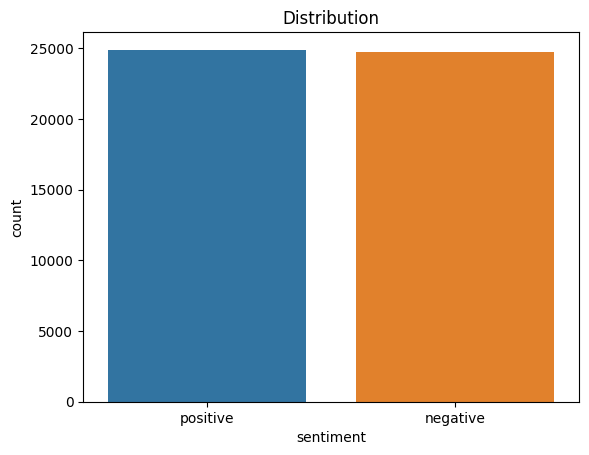

In [18]:
sns.countplot(x='sentiment', data = df)
plt.title("Distribution")

<b> From the above we can see that the positive and negative categories are nearly balanced

### Converting the categorical variable to numeric

In [19]:
le = LabelEncoder()
df['sentiment_class'] = le.fit_transform(df['sentiment'])
df.head()

,review,sentiment,cleaned_text,sentiment_class
0,One of the other reviewers has mentioned that ...,positive,one reviewer mentioned watching oz episode you...,1
1,A wonderful little production. <br /><br />The...,positive,wonderful little production filming technique ...,1
2,I thought this was a wonderful way to spend ti...,positive,thought wonderful way spend time hot summer we...,1
3,Basically there's a family where a little boy ...,negative,basically there family little boy jake think t...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,petter matteis love time money visually stunni...,1


### Splitting the data into train, validation and test set

In [20]:
X = df['cleaned_text']
y = df['sentiment_class']

In [21]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, stratify=y, random_state=1)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=1)

In [22]:
# Printing the data rows in train, validation and test set
print("The size of the training set is: ", X_train.shape)
print("The size of the validation set is: ", X_val.shape)
print("The size of the test set is: ", X_test.shape)

The size of the training set is:  (39665,)
The size of the validation set is:  (4958,)
The size of the test set is:  (4959,)


### Converting the text to Vectors

#### Converting the cleaned text into bag of words vector

In [23]:
vectorizer = CountVectorizer()
x_train_cv = vectorizer.fit_transform(X_train)
x_val_cv = vectorizer.transform(X_val)
x_test_cv = vectorizer.transform(X_test)
print("The size of the training set is: ", x_train_cv.shape)
print("The size of the validation set is: ", x_val_cv.shape)
print("The size of the test set is: ", x_test_cv.shape)

The size of the training set is:  (39665, 136450)
The size of the validation set is:  (4958, 136450)
The size of the test set is:  (4959, 136450)


#### Converting the cleaned text into TF-IDF vector

In [24]:
vectorizer_tf = TfidfVectorizer()
x_train_tf = vectorizer.fit_transform(X_train)
x_val_tf = vectorizer.transform(X_val)
x_test_tf = vectorizer.transform(X_test)
print("The size of the training set is: ", x_train_tf.shape)
print("The size of the validation set is: ", x_val_tf.shape)
print("The size of the test set is: ", x_test_tf.shape)

The size of the training set is:  (39665, 136450)
The size of the validation set is:  (4958, 136450)
The size of the test set is:  (4959, 136450)


## Hyperparameter Tuning

<b> As we have seen that the categories are balanced, hence we are using accuracy as the metric criteria for hyperparameter tuning</b>

### Hyperparameter tuning on Logistic regression model

In [25]:
# defining the parameters
parameters = {
    'penalty' : ['l1','l2'], 
    'C'       : np.logspace(-3,3,7)
}
# creating the logistic regression model object
logreg = LogisticRegression()
# creating the gridsearch object for finding the best parameters
clf = GridSearchCV(logreg,                    
                   param_grid = parameters,   
                   scoring='accuracy', verbose = 1,       
                   cv=10)                     

#### Hyperparameter tuning on bag of words training set

In [26]:
clf.fit(x_train_cv,y_train)
print("Tuned Hyperparameters :", clf.best_params_)
print("Accuracy :",clf.best_score_)

Fitting 10 folds for each of 14 candidates, totalling 140 fits
Tuned Hyperparameters : {'C': 0.1, 'penalty': 'l2'}
Accuracy : 0.8913652547790578


#### Checking the performance on bag of words validation set

In [27]:
# getting the best parameters
best_params = clf.best_params_
# creating the model with best parameters
logreg_cv = LogisticRegression(**best_params)
# training on the training set
logreg_cv.fit(x_train_cv,y_train)
# getting the prediction on validation set
log_cv_pred = logreg_cv.predict(x_val_cv)
# getting the accuracy on validation set
val_acc_cv = accuracy_score(y_val, log_cv_pred)
# printing the validation accuracy
print(f"Validation Accuracy: {val_acc_cv * 100:.2f}%")

Validation Accuracy: 88.95%


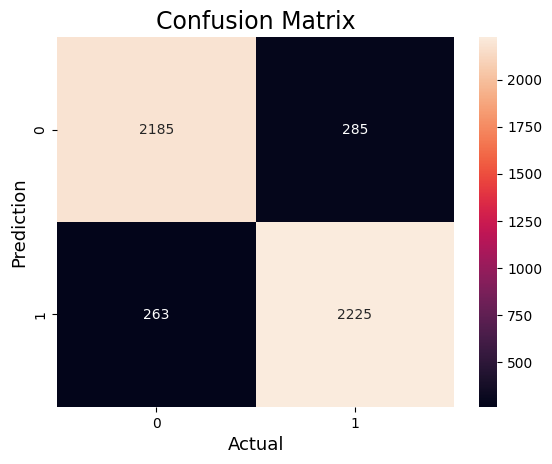

In [28]:
# Plotting a Confusion Matrix in Seaborn
conf_matrix = confusion_matrix(y_val, log_cv_pred, labels=logreg_cv.classes_)
sns.heatmap(conf_matrix,
            annot=True,
            fmt='g',
            xticklabels=logreg_cv.classes_,
            yticklabels=logreg_cv.classes_,
    )
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()

In [29]:
print('Precision: %.3f' % precision_score(y_val, log_cv_pred))
print('Recall: %.3f' % recall_score(y_val, log_cv_pred))
print('F1-Score: %.3f' % f1_score(y_val, log_cv_pred))

Precision: 0.886
Recall: 0.894
F1-Score: 0.890


#### Hyperparameter Tuning on TF-IDF training set

In [30]:
clf.fit(x_train_tf,y_train)
print("Tuned Hyperparameters :", clf.best_params_)
print("Accuracy :",clf.best_score_)

Fitting 10 folds for each of 14 candidates, totalling 140 fits
Tuned Hyperparameters : {'C': 0.1, 'penalty': 'l2'}
Accuracy : 0.8913652547790578


#### Checking the perfomance on TF-IDF validation set

In [31]:
# getting the best parameters
best_params = clf.best_params_
# creating the model with best parameters
logreg_tf = LogisticRegression(**best_params)
# training on the training set
logreg_tf.fit(x_train_tf,y_train)
# getting the prediction on validation set
log_tf_pred = logreg_tf.predict(x_val_tf)
# getting the accuracy on validation set
val_acc_tf = accuracy_score(y_val, log_tf_pred)
# printing the validation accuracy
print(f"Validation Accuracy: {val_acc_tf * 100:.2f}%")

Validation Accuracy: 88.95%


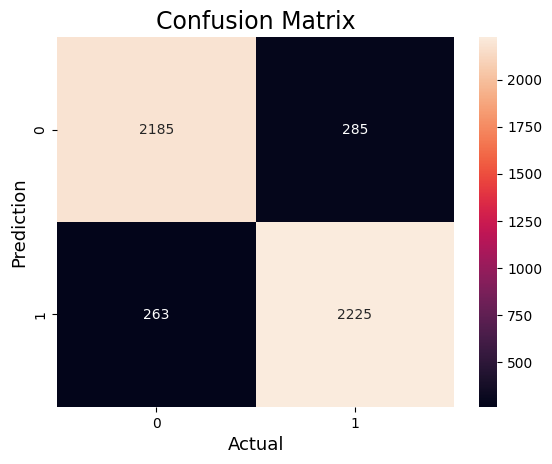

In [32]:
# Plotting a Confusion Matrix in Seaborn
conf_matrix = confusion_matrix(y_val, log_tf_pred, labels=logreg_tf.classes_)
sns.heatmap(conf_matrix,
            annot=True,
            fmt='g',
            xticklabels=logreg_tf.classes_,
            yticklabels=logreg_tf.classes_,
    )
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()

In [33]:
print('Precision: %.3f' % precision_score(y_val, log_tf_pred))
print('Recall: %.3f' % recall_score(y_val, log_tf_pred))
print('F1-Score: %.3f' % f1_score(y_val, log_tf_pred))

Precision: 0.886
Recall: 0.894
F1-Score: 0.890


### Hyperparameter tuning on Naive bayes model

In [34]:
# creating the Multinomial Naive Bayes model object
NB = MultinomialNB()
# defining the parameters
params_NB = {'alpha': [0.1, 0.5, 1.0, 2.0],
            'fit_prior': [True, False]}
# creating the gridsearch object for finding the best parameters
clf_NB = GridSearchCV(NB, 
                 param_grid=params_NB,
                 cv = 10,
                 verbose=1, 
                 scoring='accuracy')

#### Hyperparameter tuning on bag of words training set

In [35]:
clf_NB.fit(x_train_cv,y_train)
print("Tuned Hyperparameters :", clf_NB.best_params_)
print("Accuracy :",clf_NB.best_score_)

Fitting 10 folds for each of 8 candidates, totalling 80 fits
Tuned Hyperparameters : {'alpha': 1.0, 'fit_prior': False}
Accuracy : 0.8573302552411404


#### Checking the performance on bag of words validation set

In [36]:
# getting the best parameters
best_params = clf_NB.best_params_
# creating the model with best parameters
NB_cv = MultinomialNB(**best_params)
# training on the training set
NB_cv.fit(x_train_cv,y_train)
# getting the prediction on validation set
NB_cv_pred = NB_cv.predict(x_val_cv)
# getting the accuracy on validation set
val_acc_cv = accuracy_score(y_val, NB_cv_pred)
# printing the validation accuracy
print(f"Validation Accuracy: {val_acc_cv * 100:.2f}%")

Validation Accuracy: 85.11%


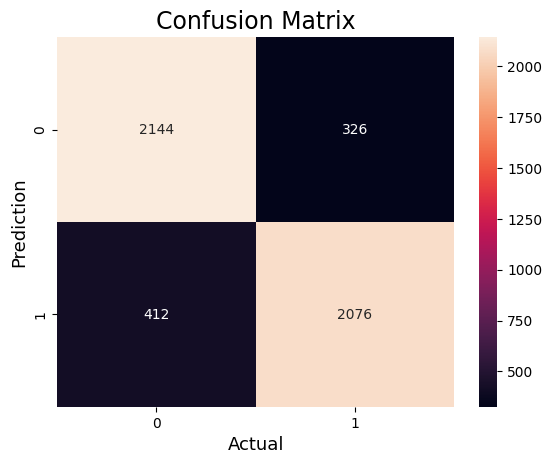

In [37]:
# Plotting a Confusion Matrix in Seaborn
conf_matrix = confusion_matrix(y_val, NB_cv_pred, labels=NB_cv.classes_)
sns.heatmap(conf_matrix,
            annot=True,
            fmt='g',
            xticklabels=NB_cv.classes_,
            yticklabels=NB_cv.classes_,
    )
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()

In [38]:
print('Precision: %.3f' % precision_score(y_val, NB_cv_pred))
print('Recall: %.3f' % recall_score(y_val, NB_cv_pred))
print('F1-Score: %.3f' % f1_score(y_val, NB_cv_pred))

Precision: 0.864
Recall: 0.834
F1-Score: 0.849


#### Hyperparameter tuning on TF-IDF training set

In [39]:
clf_NB.fit(x_train_tf,y_train)
print("Tuned Hyperparameters :", clf_NB.best_params_)
print("Accuracy :",clf_NB.best_score_)

Fitting 10 folds for each of 8 candidates, totalling 80 fits
Tuned Hyperparameters : {'alpha': 1.0, 'fit_prior': False}
Accuracy : 0.8573302552411404


#### Checking the performance on TF-IDF validation set

In [40]:
# getting the best parameters
best_params = clf_NB.best_params_
# creating the model with best parameters
NB_tf = MultinomialNB(**best_params)
# training on the training set
NB_tf.fit(x_train_tf,y_train)
# getting the prediction on validation set
NB_tf_pred = NB_tf.predict(x_val_tf)
# getting the accuracy on validation set
val_acc_tf = accuracy_score(y_val,NB_tf_pred)
# printing the validation accuracy
print(f"Validation Accuracy: {val_acc_tf * 100:.2f}%")

Validation Accuracy: 85.11%


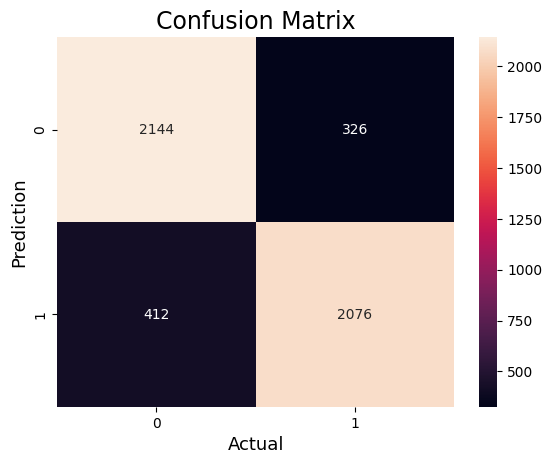

In [41]:
# Plotting a Confusion Matrix in Seaborn
conf_matrix = confusion_matrix(y_val, NB_tf_pred, labels=NB_tf.classes_)
sns.heatmap(conf_matrix,
            annot=True,
            fmt='g',
            xticklabels=NB_tf.classes_,
            yticklabels=NB_tf.classes_,
    )
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()

In [42]:
print('Precision: %.3f' % precision_score(y_val, NB_tf_pred))
print('Recall: %.3f' % recall_score(y_val, NB_tf_pred))
print('F1-Score: %.3f' % f1_score(y_val,NB_tf_pred))

Precision: 0.864
Recall: 0.834
F1-Score: 0.849


### Hyperparameter tuning on Decision Tree model

In [43]:
# creating the decision tree model object
DT = DecisionTreeClassifier()
# defining the parameters
param_DT = {
    'max_depth': [None, 10, 20, 30],              
    'min_samples_split': [2, 5, 10],              
    'min_samples_leaf': [1, 2, 4],      
    'criterion': ['gini', 'entropy']
    }
# creating the gridsearch object for finding the best parameters
clf_DT = GridSearchCV(DT, 
                 param_grid=param_DT,
                 cv = 3,
                 verbose=1, 
                 scoring='accuracy')

#### Hyperparameter tuning on bag of words training set

In [44]:
clf_DT.fit(x_train_cv,y_train)
print("Tuned Hyperparameters :", clf_DT.best_params_)
print("Accuracy :",clf_DT.best_score_)

Fitting 3 folds for each of 72 candidates, totalling 216 fits
Tuned Hyperparameters : {'criterion': 'gini', 'max_depth': 30, 'min_samples_leaf': 2, 'min_samples_split': 2}
Accuracy : 0.7405016670989313


#### Checking the performance on bag of words validation set

In [45]:
# getting the best parameters
best_params = clf_DT.best_params_
# creating the model with best parameters
DT_cv = DecisionTreeClassifier(**best_params)
# training on the training set
DT_cv.fit(x_train_cv,y_train)
# getting the prediction on validation set
DT_cv_pred = DT_cv.predict(x_val_cv)
# getting the accuracy on validation set
val_acc_cv = accuracy_score(y_val, DT_cv_pred)
# printing the validation accuracy
print(f"Validation Accuracy: {val_acc_cv * 100:.2f}%")

Validation Accuracy: 73.40%


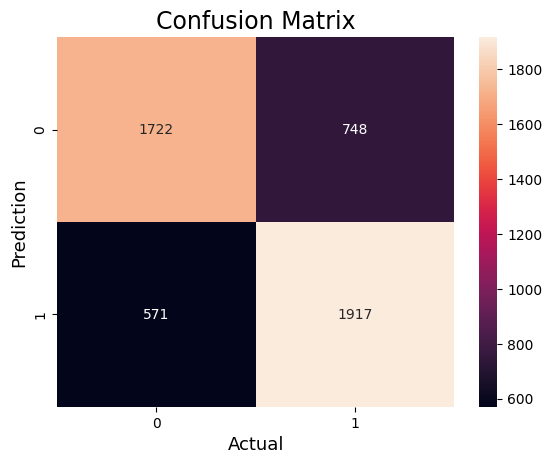

In [46]:
# Plotting a Confusion Matrix in Seaborn
conf_matrix = confusion_matrix(y_val, DT_cv_pred, labels=DT_cv.classes_)
sns.heatmap(conf_matrix,
            annot=True,
            fmt='g',
            xticklabels=DT_cv.classes_,
            yticklabels=DT_cv.classes_,
    )
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()

In [47]:
print('Precision: %.3f' % precision_score(y_val, DT_cv_pred))
print('Recall: %.3f' % recall_score(y_val, DT_cv_pred))
print('F1-Score: %.3f' % f1_score(y_val,DT_cv_pred))

Precision: 0.719
Recall: 0.770
F1-Score: 0.744


#### Hyperparameter tuning on TF-IDF training set

In [48]:
clf_DT.fit(x_train_tf,y_train)
print("Tuned Hyperparameters :", clf_DT.best_params_)
print("Accuracy :",clf_DT.best_score_)

Fitting 3 folds for each of 72 candidates, totalling 216 fits
Tuned Hyperparameters : {'criterion': 'gini', 'max_depth': 30, 'min_samples_leaf': 2, 'min_samples_split': 5}
Accuracy : 0.7411319259787152


#### Checking the performance on TF-IDF validation set

In [49]:
# getting the best parameters
best_params = clf_DT.best_params_
# creating the model with best parameters
DT_tf = DecisionTreeClassifier(**best_params)
# training on the training set
DT_tf.fit(x_train_tf,y_train)
# getting the prediction on validation set
DT_tf_pred = DT_cv.predict(x_val_tf)
# getting the accuracy on validation set
val_acc_tf = accuracy_score(y_val, DT_tf_pred)
# printing the validation accuracy
print(f"Validation Accuracy: {val_acc_tf * 100:.2f}%")

Validation Accuracy: 73.40%


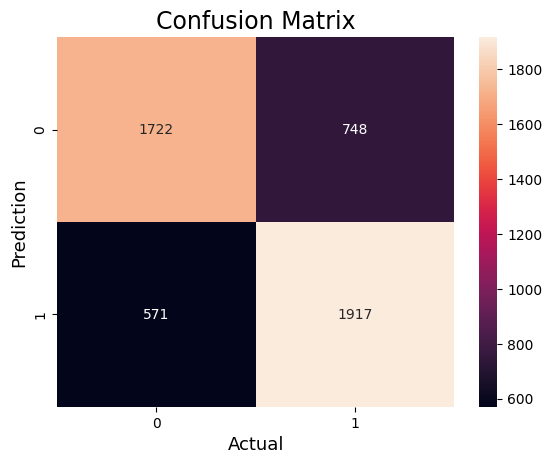

In [50]:
# Plotting a Confusion Matrix in Seaborn
conf_matrix = confusion_matrix(y_val, DT_tf_pred, labels=DT_tf.classes_)
sns.heatmap(conf_matrix,
            annot=True,
            fmt='g',
            xticklabels=DT_tf.classes_,
            yticklabels=DT_tf.classes_,
    )
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()

In [51]:
print('Precision: %.3f' % precision_score(y_val, DT_tf_pred))
print('Recall: %.3f' % recall_score(y_val, DT_tf_pred))
print('F1-Score: %.3f' % f1_score(y_val,DT_tf_pred))

Precision: 0.719
Recall: 0.770
F1-Score: 0.744


### Checking the performance of all the models on the bag of words test set

#### Logistic regression

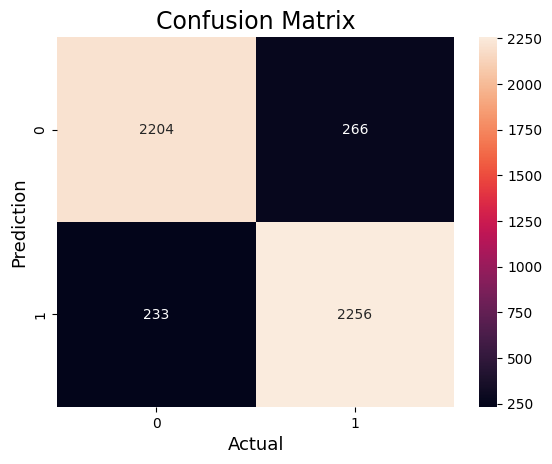

Accuracy:  0.899
Precision: 0.895
Recall: 0.906
F1-Score: 0.900


In [52]:
# getting the prediction on test set
log_cv_pred = logreg_cv.predict(x_test_cv)

# Plotting a Confusion Matrix in Seaborn
conf_matrix = confusion_matrix(y_test, log_cv_pred, labels=logreg_cv.classes_)
sns.heatmap(conf_matrix,
            annot=True,
            fmt='g',
            xticklabels=logreg_cv.classes_,
            yticklabels=logreg_cv.classes_,
    )
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()
# Printing the metrics on test set
print("Accuracy:  %.3f" % accuracy_score(y_test, log_cv_pred))
print('Precision: %.3f' % precision_score(y_test, log_cv_pred))
print('Recall: %.3f' % recall_score(y_test, log_cv_pred))
print('F1-Score: %.3f' % f1_score(y_test, log_cv_pred))

#### Naive Bayes

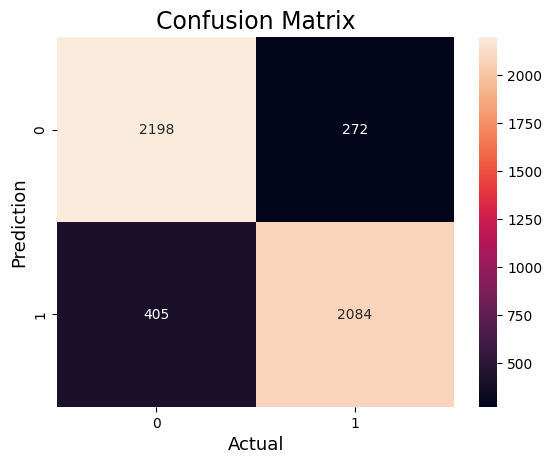

Accuracy:  0.863
Precision: 0.885
Recall: 0.837
F1-Score: 0.860


In [53]:
# getting the prediction on test set
NB_cv_pred = NB_cv.predict(x_test_cv)

# Plotting a Confusion Matrix in Seaborn
conf_matrix = confusion_matrix(y_test, NB_cv_pred, labels=NB_cv.classes_)
sns.heatmap(conf_matrix,
            annot=True,
            fmt='g',
            xticklabels=NB_cv.classes_,
            yticklabels=NB_cv.classes_,
    )
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()
# Printing the metrics on test set
print("Accuracy:  %.3f" % accuracy_score(y_test, NB_cv_pred))
print('Precision: %.3f' % precision_score(y_test, NB_cv_pred))
print('Recall: %.3f' % recall_score(y_test, NB_cv_pred))
print('F1-Score: %.3f' % f1_score(y_test, NB_cv_pred))

#### Decision Tree

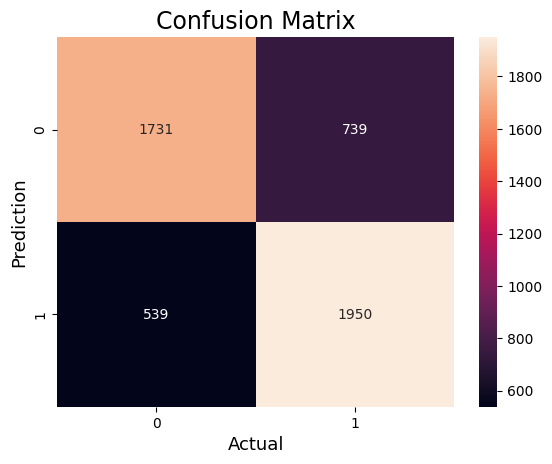

Accuracy:  0.742
Precision: 0.725
Recall: 0.783
F1-Score: 0.753


In [54]:
# getting the prediction on test set
DT_cv_pred = DT_cv.predict(x_test_cv)

# Plotting a Confusion Matrix in Seaborn
conf_matrix = confusion_matrix(y_test, DT_cv_pred, labels=DT_cv.classes_)
sns.heatmap(conf_matrix,
            annot=True,
            fmt='g',
            xticklabels=DT_cv.classes_,
            yticklabels=DT_cv.classes_,
    )
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()
# Printing the metrics on test set
print("Accuracy:  %.3f" % accuracy_score(y_test, DT_cv_pred))
print('Precision: %.3f' % precision_score(y_test, DT_cv_pred))
print('Recall: %.3f' % recall_score(y_test, DT_cv_pred))
print('F1-Score: %.3f' % f1_score(y_test, DT_cv_pred))

<b> As we see above performance of the models on test data, we can see that Logistic Regression did a much better job followed by Naive bayes and then Decision Tree</b>

### Checking the performance of all the models on the TF-IDF test set

#### Logistic Regression

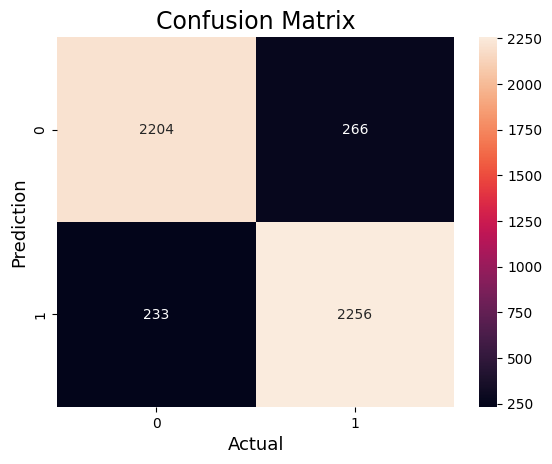

Accuracy:  0.899
Precision: 0.895
Recall: 0.906
F1-Score: 0.900


In [57]:
# getting the prediction on test set
log_tf_pred = logreg_tf.predict(x_test_tf)

# Plotting a Confusion Matrix in Seaborn
conf_matrix = confusion_matrix(y_test, log_tf_pred, labels=logreg_tf.classes_)
sns.heatmap(conf_matrix,
            annot=True,
            fmt='g',
            xticklabels=logreg_tf.classes_,
            yticklabels=logreg_tf.classes_,
    )
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()
# Printing the metrics on test set
print("Accuracy:  %.3f" % accuracy_score(y_test, log_tf_pred))
print('Precision: %.3f' % precision_score(y_test, log_tf_pred))
print('Recall: %.3f' % recall_score(y_test, log_tf_pred))
print('F1-Score: %.3f' % f1_score(y_test, log_tf_pred))

#### Naive Bayes

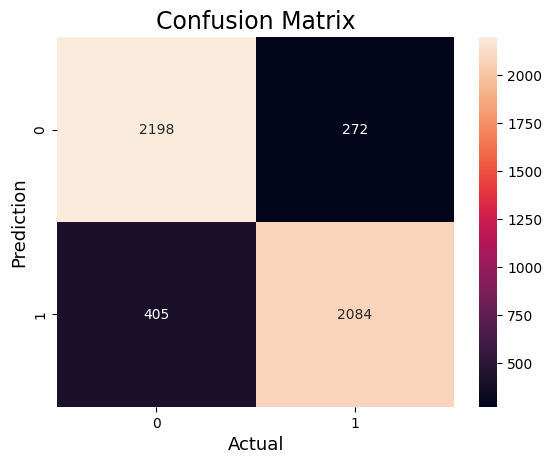

Accuracy:  0.863
Precision: 0.885
Recall: 0.837
F1-Score: 0.860


In [58]:
# getting the prediction on test set
NB_tf_pred = NB_tf.predict(x_test_tf)

# Plotting a Confusion Matrix in Seaborn
conf_matrix = confusion_matrix(y_test, NB_tf_pred, labels=NB_tf.classes_)
sns.heatmap(conf_matrix,
            annot=True,
            fmt='g',
            xticklabels=NB_tf.classes_,
            yticklabels=NB_tf.classes_,
    )
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()
# Printing the metrics on test set
print("Accuracy:  %.3f" % accuracy_score(y_test, NB_tf_pred))
print('Precision: %.3f' % precision_score(y_test, NB_tf_pred))
print('Recall: %.3f' % recall_score(y_test, NB_tf_pred))
print('F1-Score: %.3f' % f1_score(y_test, NB_tf_pred))

#### Decision Tree

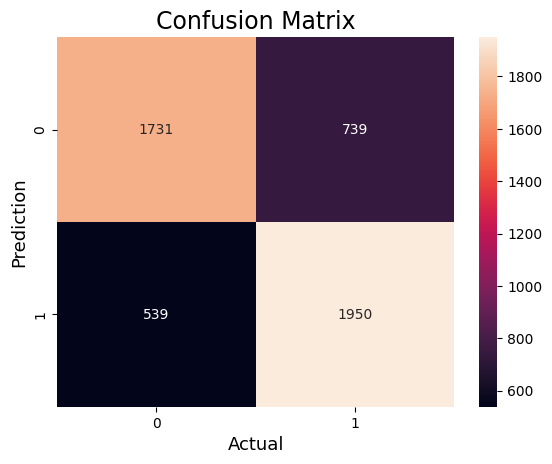

Accuracy:  0.742
Precision: 0.725
Recall: 0.783
F1-Score: 0.753


In [59]:
# getting the prediction on test set
DT_tf_pred = DT_cv.predict(x_test_tf)

# Plotting a Confusion Matrix in Seaborn
conf_matrix = confusion_matrix(y_test, DT_tf_pred, labels=DT_tf.classes_)
sns.heatmap(conf_matrix,
            annot=True,
            fmt='g',
            xticklabels=DT_tf.classes_,
            yticklabels=DT_tf.classes_,
    )
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()
# Printing the metrics on test set
print("Accuracy:  %.3f" % accuracy_score(y_test, DT_tf_pred))
print('Precision: %.3f' % precision_score(y_test, DT_tf_pred))
print('Recall: %.3f' % recall_score(y_test, DT_tf_pred))
print('F1-Score: %.3f' % f1_score(y_test, DT_tf_pred))

<b> As we see above performance of the models on test data, we can see that Logistic Regression did a much better job followed by Naive bayes and then Decision Tree.</b>

#### Overall we can see same performance on the Bag of words and TF-IDF for each model respectively. Logistic regression is having same metrics for BOW and TF-IDF dataset and same can be observed for Naive Bayes and Decision Tree